Este notebook contiene, de forma detallada y simplificada, todo el proceso de generación de embeddings usando el modelo, con arquitectura Transformer, pre-entrenado en el cuerpo humano, de scGPT. Probaremos al modelo sobre datos de esclerosis múltiple, buscando contrastar los resultados con los mostrados por el equipo de desarrollo del propio modelo en el artículo de "presentación".

El anterior párrafo muestra la idea originaria. En realidad, el notebook me sirve para contrastar los resultados de los embeddings generados en mi propio terminal con los generados por GPU's de Google Colab. Las dependencias que muestro a continuación sí que son reales y se deben considerar.

El primer paso consiste en importar las librerías y paquetes que nos serán necesarios. 

A 27/01/2025, debemos tener en cuenta las siguientes dependencias entre librerías:

-scgpt requiere 3.7<= Python <3.11, lo cual hace que no se puede emplear en Google Colab.

-pytorch==2.1.2

-numpy<2

In [3]:

import warnings
import urllib.request
from pathlib import Path
import os

import torch
import scgpt as scg
import scanpy as sc
import numpy as np
import pandas as pd
import gdown


warnings.filterwarnings("ignore")

/Users/doblado/miniforge3/envs/envTFG/lib/python3.10/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/Users/doblado/miniforge3/envs/envTFG/lib/python3.10/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


El primer paso consiste en descargar el modelo pre-entrenado del enlace proporcionado en el github de el laboratorio de Bo wang: 
https://github.com/bowang-lab/scGPT . Nos aseguramos de que solo se nos descargue una vez. Por medio del campo folder_id podremos descargar cualquier otro modelo si así lo deseamos.

In [ ]:
warnings.simplefilter("ignore", ResourceWarning)
warnings.filterwarnings("ignore", category=ImportWarning)

output_dir = "../Experimentacion/save/scGPT_human"
if os.path.exists(output_dir):
    print("model checkpoint already downloaded!!")
else:

    # En caso de usar otro modelo, introduce su ID
    folder_id = "1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y"

    gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", output=output_dir, quiet=False)

Seguimos con la descarga de los datos, como ya hemos mencionado usaremos datos de esclerosis múltiple, en concreto los proporcionados por el propio equipo de desarrollo. El siguiente código debería ser modificado en función de si descargamos una carpeta en Google Drive, como es nuestro caso, o si simplemente descargamos un archivo de un sitio web, como es el caso en "quickStart.ipynb".

En la última línea leemos los datos del formado .h5ad gracias a la librería scanpy.

In [7]:
output_dir = "../Experimentacion/data/ms"
if os.path.exists(output_dir):
    print("data already downloaded!!")
else:

    # En caso de usar otros datos, cambia el ID
    folder_id = "1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v"

    gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", output=output_dir, quiet=False)
    
adata = sc.read_h5ad("/Users/doblado/Transformers-Architecture-in-Bioinformatics/Experimentacion/data/ms/esclerosis_scGPT_data.h5ad")

data already downloaded!!


Una vez está todo listo, podemos comenzar a trabajar sobre los datos para entender a qué nos enfrentamos y cómo vamos a abordarlo. Primero, echemos un vistazo rápido a los datos, que se almacenan en un objeto de tipo AnnData.

In [7]:
adata

AnnData object with n_obs × n_vars = 7844 × 3000
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling site]', 'Sample Characteristic Ontology Term[sampling site]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Sample Characteristic[clinical history]', 'Sample C

In [8]:
batch_key = "sample"
N_HVG = 3000

"""
    Filtramos el dataset para obtener aquellos genes con una mayor variabilidad y que más
    info nos aportan
"""
sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata_hvg = adata[:, adata.var['highly_variable']]

adata_hvg

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


View of AnnData object with n_obs × n_vars = 7844 × 3000
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling site]', 'Sample Characteristic Ontology Term[sampling site]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Sample Characteristic[clinical history]', '

Una vez trabajados los datos, vamos a generar los embeddings. 

Para que la función embed_data funcione, debemos aplicar un par de cambios en su código fuente. Para ello, haz doble click sobre la misma y pincha en "Ir a definición". Una vez allí, deberás buscar la línea de código 53, en la que pone ".A", y sustituirlo por ".toarray()". También, deberás buscar la línea 258 y añadir a "torch.load()" el parámetro map_location = device.

Tras cambiar esto, debería funcionar. Yo los obtuve en unos 40 minutos, haciendo uso del 65-75% de uso de una CPU amd ryzen 5600 xt, empleando 20GB de RAM de un total de 32.

In [ ]:
model_dir = Path("../Transformers-Architecture-in-Bioinformatics/Experimentacion/save/scGPT_human")



gene_col = "feature_name"
cell_type_key = "cell_type"

ref_embed_adata = scg.tasks.embed_data(
    adata_hvg,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

Una vez obtenidos, podemos ver como queda el objeto AnnData generado.

In [ ]:
ref_embed_adata

Ahora, vamos a visualizarlos haciendo uso de un UMAP. Sin embargo, primero debemos aplicar un par de funciones que buscan reducir la dimensionalidad de los datos.

In [ ]:
sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)

También, para la representación, añadiremos los nuevos datos calculados a las variables originales que los contenían. Por último, nos aseguramos de guardar los embeddings de forma permanente para no tener que volver a esperar a todo el procesamiento de su generación.

In [ ]:
adata.obsm["X_scgpt"] = ref_embed_adata.X
adata.obsm["X_umap"] = ref_embed_adata.obsm["X_umap"]

# Añadimos el índice actual como una columna
adata.var['ensembl_id'] = adata.var.index
# Le modificamos el nombre a esta
adata.var.set_index('feature_name', inplace=True)
# Añadimos una copia del símbolo de los genes a var
adata.var['gene_symbol'] = adata.var.index

adata.write("/home/pablo/git/Transformers-Architecture-in-Bioinformatics/Experimentacion/scGPT_embeddings/first_get_started_embeddings.h5ad")

Ahora ya sí, pasamos a visualizar los resultados, asegurándonos también de almacenarlos.

In [4]:
import anndata as ad

ms_colab_emb = ad.read_h5ad("/Users/doblado/Transformers-Architecture-in-Bioinformatics/Experimentacion/embeddings_generated/embeddings_ms_colab.h5ad")

ms_colab_emb.X

array([[ 0.04460489, -0.00262826, -0.0084925 , ..., -0.01984312,
        -0.02740908, -0.04910286],
       [ 0.02978314, -0.01304677, -0.01859896, ..., -0.02379036,
        -0.03768331, -0.02258573],
       [ 0.05291918, -0.0149627 , -0.00859597, ..., -0.01143246,
        -0.03469072, -0.04141134],
       ...,
       [ 0.02575698,  0.0165769 , -0.01884174, ..., -0.01819961,
        -0.00446987, -0.04814608],
       [ 0.04291804, -0.02048758,  0.00906298, ..., -0.01793252,
        -0.03402103, -0.03232814],
       [ 0.03583027, -0.01702758, -0.0208754 , ..., -0.03010729,
        -0.03629039, -0.03333387]], dtype=float32)

In [5]:
sc.pp.neighbors(ms_colab_emb, use_rep="X")
sc.tl.umap(ms_colab_emb)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
adata.obsm["X_scgpt"] = ms_colab_emb.X
adata.obsm["X_umap"] = ms_colab_emb.obsm["X_umap"]



In [13]:
adata

AnnData object with n_obs × n_vars = 7844 × 3000
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling site]', 'Sample Characteristic Ontology Term[sampling site]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Sample Characteristic[clinical history]', 'Sample C

In [14]:
output_umap = "genEmbeddings_figures"
os.makedirs(output_umap, exist_ok=True)
sc.settings.figdir = output_umap

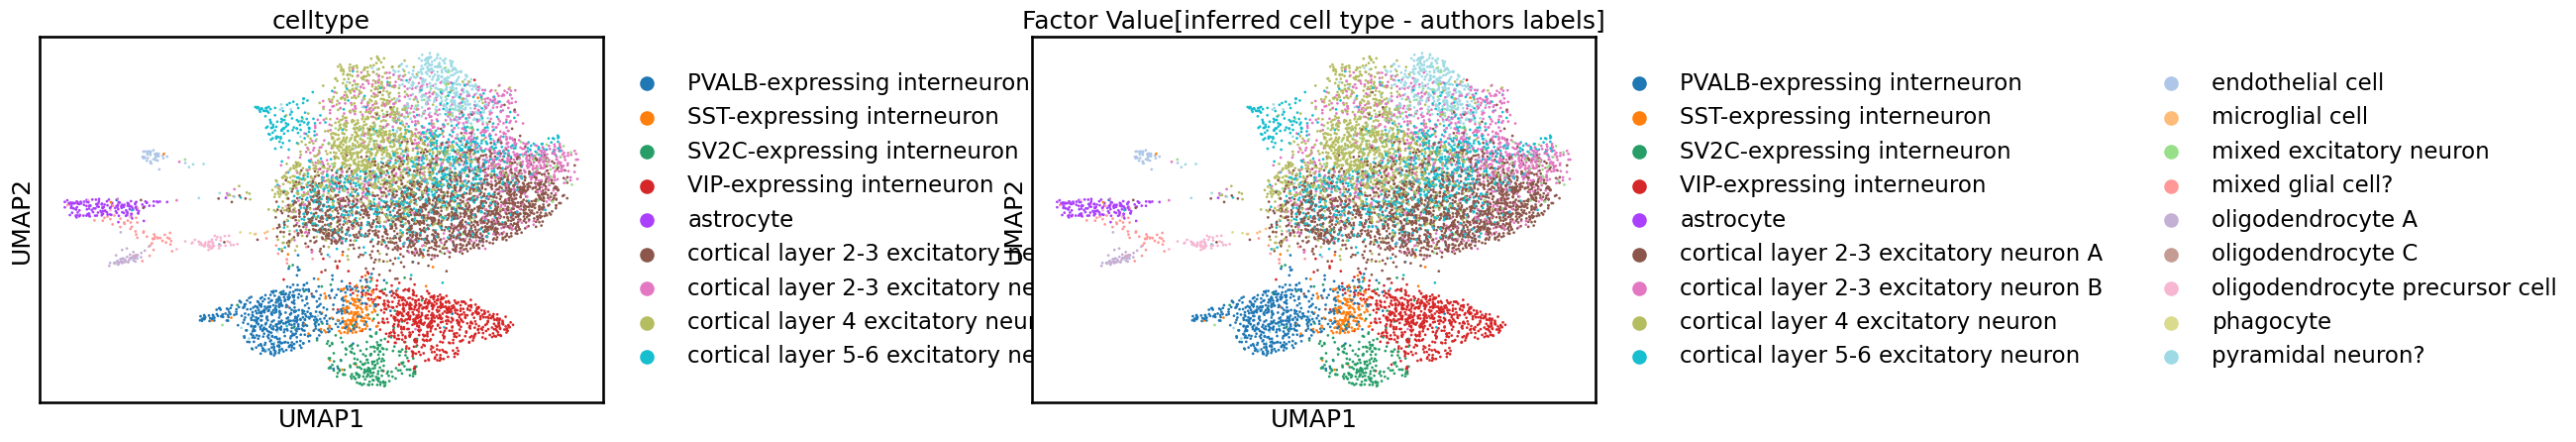

In [15]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    #sc.pp.neighbors(ref_embed_adata, use_rep="X")
    #sc.tl.umap(ref_embed_adata)
    sc.pl.umap(adata, color=["celltype", "Factor Value[inferred cell type - authors labels]"], wspace = 0.6, save="ms_colab.png")

Para terminar, puedes ubicar a genes de forma individual en el mapa total de embeddings.

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'MKI67', 'LYZ', 'RBP2', 'MUC2', 'CHGA', 'TAGLN', 'ELAVL3'], frameon=False, use_raw=False, legend_fontsize ="xx-small", legend_loc="none", save="get_started_markers.png")